<a href="https://colab.research.google.com/github/vuthanhcdt/irobot_course/blob/main/humanoid_h1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training the Humanoid Robot H1: A Reinforcement Learning Approach

This notebook is introduced by the [Network Robotics System Laboratory (NRSL)](https://sites.google.com/site/yenchenliuncku) and is designed to train the humanoid robot H1 from Unitree [H1 Robot](https://www.unitree.com/h1). The source code is built upon [MuJoCo Playground](https://playground.mujoco.org/) and runs in a [MuJoCo](https://mujoco.org/) environment by Google DeepMind, which allows training policies in minutes on a single GPU with the [MuJoCo XLA (MJX) library](https://github.com/google-deepmind/mujoco/tree/main/mjx), a JAX-based implementation of MuJoCo, useful for reinforcement learning (RL) training workloads.

# Install MuJoCo, MJX, and Brax

In [1]:
#@title Install pre-requisites
!pip install mujoco
!pip install mujoco_mjx
!pip install brax
!pip install playground

In [ ]:
#@title Check if MuJoCo installation was successful

from google.colab import files  # Use this if you are using Google Colab. If you are using a local machine, this may not work.

import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags


Mon Apr 14 14:30:31 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               Off | 00000000:AC:00.0  On |                  Off |
| 30%   55C    P2              76W / 300W |    752MiB / 49140MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
#@title Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Installing mediapy:


In [10]:
#@title Import MuJoCo, MJX, and Brax
from datetime import datetime
from etils import epath
import functools
from IPython.display import HTML
from typing import Any, Dict, Sequence, Tuple, Union
from typing import Any, Dict, Optional, Union
import os
from ml_collections import config_dict
import imageio
import jax
from jax import numpy as jp
import numpy as np
from flax.training import orbax_utils
from flax import struct
from matplotlib import pyplot as plt
import mediapy as media
from orbax import checkpoint as ocp

import mujoco
from mujoco import mjx

from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.base import State as PipelineState
from brax.envs.base import Env, PipelineEnv, State
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks
from brax.io import html, mjcf, model
from typing import Any, Tuple
from mujoco_playground._src import collision
from mujoco_playground._src import gait
from mujoco_playground._src import mjx_env
from mujoco_playground._src.locomotion.h1 import base as h1_base
from mujoco_playground._src.locomotion.h1 import h1_constants as consts
from mujoco_playground.config import locomotion_params
from mujoco_playground import wrapper
from mujoco_playground import registry


## Humanoid Unitree H1 Environment

Let's define a Humanoid Unitree H1 environment. To define the environment, modify the reward function, and support other robots, refer to the [MuJoCo Playground](https://playground.mujoco.org/) for more details.

In [5]:
_PHASES = np.array([
    [0, np.pi],  # walk
    [0, 0],  # jump
])


def default_config() -> config_dict.ConfigDict:
  return config_dict.create(
      ctrl_dt=0.02,
      sim_dt=0.004,
      episode_length=1000,
      early_termination=True,
      action_repeat=1,
      action_scale=0.3,
      history_len=1,
      obs_noise=config_dict.create(
          level=0.6,
          scales=config_dict.create(
              joint_pos=0.01,
              joint_vel=1.5,
              gyro=0.2,
              gravity=0.05,
          ),
      ),
      reward_config=config_dict.create(
          scales=config_dict.create(
              # Rewards.
              feet_phase=5.0,
              tracking_lin_vel=3.5,
              tracking_ang_vel=0.75,
              feet_air_time=0.0,
              # Costs.
              ang_vel_xy=-0.0,
              lin_vel_z=-0.0,
              pose=-2.5,
              foot_slip=-0.0,
              action_rate=-0.01,
          ),
          tracking_sigma=0.5,
      ),
      command_config=config_dict.create(
          lin_vel_x=[-1.5, 1.5],
          lin_vel_y=[-0.5, 0.5],
          ang_vel_yaw=[-1.0, 1.0],
          lin_vel_threshold=0.1,
          ang_vel_threshold=0.1,
      ),
      gait_frequency=[0.5, 2.0],
      gaits=["walk"],
      foot_height=[0.08, 0.4],
  )


class JoystickGaitTracking(h1_base.H1Env):
  """
  A class for tracking joystick-controlled gait in a simulated environment.
  """

  def __init__(
      self,
      config: config_dict.ConfigDict = default_config(),
      config_overrides: Optional[Dict[str, Union[str, int, list[Any]]]] = None,
  ):


    super().__init__(
        # xml_path = epath.Path('unitree_h1/scene_mjx_feetonly.xml').as_posix(),
        xml_path=consts.FEET_ONLY_XML.as_posix(),
        config=config,
        config_overrides=config_overrides,
    )
    self._config = config
    self._post_init()

  def _post_init(self) -> None:
    self._init_q = jp.array(self._mj_model.keyframe("home").qpos)
    self._default_pose = self._mj_model.keyframe("home").qpos[7:]
    self._lowers = self._mj_model.actuator_ctrlrange[:, 0]
    self._uppers = self._mj_model.actuator_ctrlrange[:, 1]

    self._hx_idxs = jp.array([
        0, 1, 4,  # left leg
        5, 6, 9,  # right leg
        10,  # torso
        11, 12, 13, 14,  # left arm
        15, 16, 17, 18,  # right arm
    ])  # fmt: skip
    self._weights = jp.array([
        5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 2.0, 1.0, 1.0, 1.0, 1.0,
        1.0, 1.0, 1.0, 1.0,
    ])  # fmt: skip

    self._hx_default_pose = self._default_pose[self._hx_idxs]

    self._feet_site_id = np.array(
        [self._mj_model.site(name).id for name in consts.FEET_SITES]
    )
    self._floor_geom_id = self._mj_model.geom("floor").id
    self._left_feet_geom_id = np.array(
        [self._mj_model.geom(name).id for name in consts.LEFT_FEET_GEOMS]
    )
    self._right_feet_geom_id = np.array(
        [self._mj_model.geom(name).id for name in consts.RIGHT_FEET_GEOMS]
    )
    foot_linvel_sensor_adr = []
    for site in consts.FEET_SITES:
      sensor_id = self._mj_model.sensor(f"{site}_global_linvel").id
      sensor_adr = self._mj_model.sensor_adr[sensor_id]
      sensor_dim = self._mj_model.sensor_dim[sensor_id]
      foot_linvel_sensor_adr.append(
          list(range(sensor_adr, sensor_adr + sensor_dim))
      )
    self._foot_linvel_sensor_adr = jp.array(foot_linvel_sensor_adr)

  def reset(self, rng: jax.Array) -> mjx_env.State:
    rng, noise_rng, gait_freq_rng, gait_rng, foot_height_rng, cmd_rng = (  # pylint: disable=redefined-outer-name
        jax.random.split(rng, 6)
    )

    data = mjx_env.init(
        self.mjx_model, qpos=self._init_q, qvel=jp.zeros(self.mjx_model.nv)
    )

    # Initialize history buffers.
    qpos_error_history = jp.zeros(self._config.history_len * 19)
    qvel_history = jp.zeros(self._config.history_len * 19)

    # Sample gait parameters.
    gait_freq = jax.random.uniform(
        gait_freq_rng,
        minval=self._config.gait_frequency[0],
        maxval=self._config.gait_frequency[1],
    )
    phase_dt = 2 * jp.pi * self.dt * gait_freq
    gait = jax.random.randint(  # pylint: disable=redefined-outer-name
        gait_rng, minval=0, maxval=len(self._config.gaits), shape=()
    )
    phase = jp.array(_PHASES)[gait]
    foot_height = jax.random.uniform(
        foot_height_rng,
        minval=self._config.foot_height[0],
        maxval=self._config.foot_height[1],
    )

    info = {
        "command": self.sample_command(cmd_rng),
        "rng": rng,
        "last_act": jp.zeros(self.mjx_model.nu),
        "last_last_act": jp.zeros(self.mjx_model.nu),
        "step": 0,
        "motor_targets": jp.zeros(self.mjx_model.nu),
        "qpos_error_history": qpos_error_history,
        "qvel_history": qvel_history,
        "swing_peak": jp.zeros(2),
        "feet_air_time": jp.zeros(2),
        "last_contact": jp.zeros(2, dtype=bool),
        "lin_vel": jp.zeros(3),
        "ang_vel": jp.zeros(3),
        "gait_freq": gait_freq,
        "gait": gait,
        "phase": phase,
        "phase_dt": phase_dt,
        "foot_height": foot_height,
        "torques": data.actuator_force,
        "base_height": data.qpos[2]
    }

    metrics = {}
    for k in self._config.reward_config.scales.keys():
      metrics[f"reward/{k}"] = jp.zeros(())

    left_feet_contact = jp.array([
        collision.geoms_colliding(data, geom_id, self._floor_geom_id)
        for geom_id in self._left_feet_geom_id
    ])
    right_feet_contact = jp.array([
        collision.geoms_colliding(data, geom_id, self._floor_geom_id)
        for geom_id in self._right_feet_geom_id
    ])
    contact = jp.hstack([jp.any(left_feet_contact), jp.any(right_feet_contact)])
    obs = self._get_obs(data, info, noise_rng, contact)
    reward, done = jp.zeros(2)
    return mjx_env.State(data, obs, reward, done, metrics, info)

  def step(self, state: mjx_env.State, action: jax.Array) -> mjx_env.State:
    rng, cmd_rng, noise_rng = jax.random.split(state.info["rng"], 3)

    motor_targets = state.data.ctrl + action * self._config.action_scale
    motor_targets = jp.clip(motor_targets, self._lowers, self._uppers)
    data = mjx_env.step(
        self.mjx_model, state.data, motor_targets, self.n_substeps
    )
    state.info["motor_targets"] = motor_targets

    left_feet_contact = jp.array([
        collision.geoms_colliding(data, geom_id, self._floor_geom_id)
        for geom_id in self._left_feet_geom_id
    ])
    right_feet_contact = jp.array([
        collision.geoms_colliding(data, geom_id, self._floor_geom_id)
        for geom_id in self._right_feet_geom_id
    ])
    contact = jp.hstack([jp.any(left_feet_contact), jp.any(right_feet_contact)])
    contact_filt = contact | state.info["last_contact"]
    first_contact = (state.info["feet_air_time"] > 0.0) * contact_filt
    state.info["feet_air_time"] += self.dt
    p_f = data.site_xpos[self._feet_site_id]
    p_fz = p_f[..., -1]
    state.info["swing_peak"] = jp.maximum(state.info["swing_peak"], p_fz)

    obs = self._get_obs(data, state.info, noise_rng, contact)
    done = self._get_termination(data)


    # ====================================== Reward Function ============================================================
    # Compute positive and negative reward components
    pos, neg = self._get_reward(
        data, action, state.info, state.metrics, done, first_contact, contact
    )

    # Apply individual scaling factors (weights) to each reward component
    pos = {k: v * self._config.reward_config.scales[k] for k, v in pos.items()}
    neg = {k: v * self._config.reward_config.scales[k] for k, v in neg.items()}

    # Merge all components into a single dictionary
    rewards = pos | neg  # Using `|` to combine the two dictionaries (Python 3.9+)

    # ================= Optional alternative reward formulation =================
    # Sum of positive rewards
    # r_pos = sum(pos.values())
    # Exponential scaling of negative costs (to smoothly penalize large costs)
    # r_neg = jp.exp(0.2 * sum(neg.values()))
    # Final reward = positive reward × scaled penalty × time step
    # reward = r_pos * r_neg * self.dt

    # ================= Simplified reward computation (currently used) =================
    # Final reward: sum all scaled components and clip to be non-negative
    reward = jp.clip(sum(rewards.values()) * self.dt, 0.0)
    # ===============================================================================================================






    state.info["last_last_act"] = state.info["last_act"]
    state.info["last_act"] = action
    state.info["step"] += 1
    phase_tp1 = state.info["phase"] + state.info["phase_dt"]
    state.info["phase"] = jp.fmod(phase_tp1 + jp.pi, 2 * jp.pi) - jp.pi
    state.info["rng"] = rng
    state.info["feet_air_time"] *= ~contact
    state.info["last_contact"] = contact
    state.info["swing_peak"] *= ~contact

    state.info["command"] = jp.where(
        state.info["step"] > 500,
        self.sample_command(cmd_rng),
        state.info["command"],
    )
    state.info["step"] = jp.where(
        done | (state.info["step"] > 500),
        0,
        state.info["step"],
    )

    state.info["torques"] = data.actuator_force
    state.info["lin_vel"] = self.get_local_linvel(data)
    state.info["ang_vel"] = self.get_gyro(data)
    state.info["base_height"] = data.qpos[2]




    for k, v in rewards.items():
      state.metrics[f"reward/{k}"] = v

    done = done.astype(reward.dtype)
    state = state.replace(data=data, obs=obs, reward=reward, done=done)
    return state

  def _get_termination(self, data: mjx.Data) -> jax.Array:
    # Terminates if joint limits are exceeded or the robot falls.
    joint_angles = data.qpos[7:]
    joint_limit_exceed = jp.any(joint_angles < self._lowers)
    joint_limit_exceed |= jp.any(joint_angles > self._uppers)
    fall_termination = self.get_gravity(data)[-1] < 0.85
    return jp.where(
        self._config.early_termination,
        joint_limit_exceed | fall_termination,
        joint_limit_exceed,
    )

  def _get_obs(
      self,
      data: mjx.Data,
      info: dict[str, Any],
      rng: jax.Array,
      contact: jax.Array,
  ) -> jax.Array:
    obs = jp.concatenate([
        self.get_gyro(data),  # 3
        self.get_gravity(data),  # 3
        data.qpos[7:] - self._default_pose,  # 19
        data.qvel[6:],  # 19
        info["last_act"],  # 19
        info["command"],  # 3
    ])  # 66

    # Add noise.
    noise_vec = jp.zeros_like(obs)
    noise_vec = noise_vec.at[:3].set(
        self._config.obs_noise.level * self._config.obs_noise.scales.gyro
    )
    noise_vec = noise_vec.at[3:6].set(
        self._config.obs_noise.level * self._config.obs_noise.scales.gravity
    )
    noise_vec = noise_vec.at[6:25].set(
        self._config.obs_noise.level * self._config.obs_noise.scales.joint_pos
    )
    noise_vec = noise_vec.at[25:44].set(
        self._config.obs_noise.level * self._config.obs_noise.scales.joint_vel
    )
    obs = obs + (2 * jax.random.uniform(rng, shape=obs.shape) - 1) * noise_vec

    # Update history.
    qvel_history = jp.roll(info["qvel_history"], 19).at[:19].set(data.qvel[6:])
    qpos_error_history = (
        jp.roll(info["qpos_error_history"], 19)
        .at[:19]
        .set(data.qpos[7:] - info["motor_targets"])
    )
    info["qvel_history"] = qvel_history
    info["qpos_error_history"] = qpos_error_history

    cos = jp.cos(info["phase"])
    sin = jp.sin(info["phase"])
    phase = jp.concatenate([cos, sin])

    # Concatenate final observation.
    obs = jp.hstack(
        [
            obs,
            qvel_history,
            qpos_error_history,
            contact,
            phase,
            info["gait_freq"],
            info["gait"],
            info["foot_height"],
        ],
    )
    return obs

  # ====================================== Reward Function ============================================================
  # STUDENT NOTE:
  # This is the core reward function that governs the robot's behavior during training.
  # It computes and returns two sets of values:
  #     - `pos`: A dictionary of positive rewards that encourage desired behaviors.
  #     - `neg`: A dictionary of negative costs or penalties that discourage undesirable behaviors.
  #
  # You are encouraged to MODIFY or EXTEND this function to explore different robot behaviors.
  # Consider the following possibilities:
  #     ✔ Add a reward term to encourage **energy efficiency** (e.g., reducing torque usage).
  #     ✔ Implement rewards for **specific movements** like jumping, running, or maintaining balance during dynamic actions.
  #     ✔ Introduce penalties for **joint torque saturation** to avoid robot damage or inefficiencies.
  #     ✔ Experiment with tuning the **balance between tracking precision** (linear and angular velocities) and **energy efficiency**.
  # 🚨 IMPORTANT:
  # Be mindful that any changes you make will directly affect the robot's training behavior and outcomes.

  def _get_reward(
      self,
      data: mjx.Data,
      action: jax.Array,
      info: dict[str, Any],
      metrics: dict[str, Any],
      done: jax.Array,
      first_contact: jax.Array,
      contact: jax.Array,
  ) -> tuple[dict[str, jax.Array], dict[str, jax.Array]]:
    """
    Computes the reward components for the current simulation step.

    This function evaluates both positive rewards (incentives for desired behavior)
    and negative rewards (penalties for undesired or unsafe behavior). The total reward
    is typically computed as a weighted sum of these components elsewhere in the code.

    Args:
        data (mjx.Data): The current state of the simulation.
        action (jax.Array): The action applied at this timestep.
        info (dict): A dictionary containing additional state and command information.
        metrics (dict): Logging or tracking metrics (not used here).
        done (jax.Array): Indicates whether the episode has terminated (not used).
        first_contact (jax.Array): Contact indicators for detecting initial foot-ground impact.
        contact (jax.Array): Contact states of the robot's feet with the environment.

    Returns:
        Tuple of dictionaries:
            - `pos`: Dictionary of positive reward components.
            - `neg`: Dictionary of negative cost/penalty components.
    """

    del done, metrics  # These arguments are unused in this reward computation.

    # ---------------------- Positive Rewards ----------------------
    pos = {
        # Reward for accurately tracking the commanded linear velocity
        "tracking_lin_vel": self._reward_tracking_lin_vel(
            info["command"], self.get_local_linvel(data)
        ),
        # Reward for matching the commanded angular velocity (yaw rate)
        "tracking_ang_vel": self._reward_tracking_ang_vel(
            info["command"], self.get_gyro(data)
        ),
        # Encourages phase-consistent foot movements
        "feet_phase": self._reward_feet_phase(
            data, info["phase"], info["foot_height"]
        ),
        # Reward based on desired air-time of each foot (promotes dynamic walking)
        "feet_air_time": self._reward_feet_air_time(
            info["feet_air_time"], first_contact, info["command"]
        ),
    }

    # ---------------------- Negative Costs / Penalties ----------------------
    neg = {
        # Penalizes angular velocities in the XY plane (lateral instability)
        "ang_vel_xy": self._cost_ang_vel_xy(self.get_global_angvel(data)),
        # Penalizes unwanted vertical linear movement
        "lin_vel_z": self._cost_lin_vel_z(
            self.get_global_linvel(data), info["gait"]
        ),
        # Penalizes deviation from a natural pose
        "pose": self._cost_pose(data.qpos[7:]),
        # Penalizes slipping feet on contact (lack of traction)
        "foot_slip": self._cost_foot_slip(data, contact),
        # Penalizes abrupt or jerky action changes
        "action_rate": self._cost_action_rate(
            info["last_act"], info["last_last_act"], action
        ),
    }

    return pos, neg

  def _reward_feet_phase(
      self, data: mjx.Data, phase: jax.Array, foot_height: jax.Array
  ) -> jax.Array:
    # Reward for tracking the desired foot height.
    foot_pos = data.site_xpos[self._feet_site_id]
    foot_z = foot_pos[..., -1]
    rz = gait.get_rz(phase, swing_height=foot_height)
    error = jp.sum(jp.square(foot_z - rz))
    return jp.exp(-error / 0.01)

  def _reward_tracking_lin_vel(
      self,
      commands: jax.Array,
      local_vel: jax.Array,
  ) -> jax.Array:
    # Tracking of linear velocity commands (xy axes).
    lin_vel_error = jp.sum(jp.square(commands[:2] - local_vel[:2]))
    reward = jp.exp(-lin_vel_error / self._config.reward_config.tracking_sigma)
    return reward

  def _reward_tracking_ang_vel(
      self,
      commands: jax.Array,
      ang_vel: jax.Array,
  ) -> jax.Array:
    # Tracking of angular velocity commands (yaw).
    ang_vel_error = jp.square(commands[2] - ang_vel[2])
    return jp.exp(-ang_vel_error / self._config.reward_config.tracking_sigma)

  def _reward_feet_air_time(
      self, air_time: jax.Array, first_contact: jax.Array, commands: jax.Array
  ) -> jax.Array:
    # Reward air time.
    cmd_norm = jp.linalg.norm(commands[:2])
    rew_air_time = jp.sum((air_time - 0.1) * first_contact)
    rew_air_time *= cmd_norm > 0.05  # No reward for zero commands.
    return rew_air_time

  def _cost_pose(self, joint_angles: jax.Array) -> jax.Array:
    # Penalize deviation from the default pose for certain joints.
    current = joint_angles[self._hx_idxs]
    return jp.sum(jp.square(current - self._hx_default_pose) * self._weights)

  def _cost_lin_vel_z(self, global_linvel, gait: jax.Array) -> jax.Array:  # pylint: disable=redefined-outer-name
    # Penalize z axis base linear velocity unless pronk or bound.
    cost = jp.square(global_linvel[2])
    return cost * (gait > 0)

  def _cost_ang_vel_xy(self, global_angvel) -> jax.Array:
    # Penalize xy axes base angular velocity.
    return jp.sum(jp.square(global_angvel[:2]))

  def _cost_foot_slip(self, data: mjx.Data, contact: jax.Array) -> jax.Array:
    feet_vel = data.sensordata[self._foot_linvel_sensor_adr]
    vel_xy = feet_vel[..., :2]
    vel_xy_norm_sq = jp.sum(jp.square(vel_xy), axis=-1)
    return jp.sum(vel_xy_norm_sq * contact)

  def _cost_action_rate(
      self, act: jax.Array, last_act: jax.Array, last_last_act: jax.Array
  ) -> jax.Array:
    # Penalize first and second derivative of actions.
    c1 = jp.sum(jp.square(act - last_act))
    c2 = jp.sum(jp.square(act - 2 * last_act + last_last_act))
    return c1 + c2
  #======================================reward function============================================================



  def sample_command(self, rng: jax.Array) -> jax.Array:
    """Samples a random command with a 10% chance of being zero."""
    _, rng1, rng2, rng3 = jax.random.split(rng, 4)
    cmd_config = self._config.command_config
    lin_vel_x = jax.random.uniform(
        rng1, minval=cmd_config.lin_vel_x[0], maxval=cmd_config.lin_vel_x[1]
    )
    lin_vel_y = jax.random.uniform(
        rng2, minval=cmd_config.lin_vel_y[0], maxval=cmd_config.lin_vel_y[1]
    )
    ang_vel_yaw = jax.random.uniform(
        rng3,
        minval=cmd_config.ang_vel_yaw[0],
        maxval=cmd_config.ang_vel_yaw[1],
    )
    lin_vel_x = jp.where(
        jp.abs(lin_vel_x) < cmd_config.lin_vel_threshold, 0, lin_vel_x
    )
    lin_vel_y = jp.where(
        jp.abs(lin_vel_y) < cmd_config.lin_vel_threshold, 0, lin_vel_y
    )
    ang_vel_yaw = jp.where(
        jp.abs(ang_vel_yaw) < cmd_config.ang_vel_threshold, 0, ang_vel_yaw
    )
    cmd = jp.hstack([lin_vel_x, lin_vel_y, ang_vel_yaw])
    return cmd

envs.register_environment('humanoid_h1', JoystickGaitTracking)

## Visualize a Rollout

Let's instantiate the environment and visualize a short rollout without any policy. Since the robot is not controlled by a policy, it will fall over.


In [6]:
# instantiate the environment
env_name = 'humanoid_h1'
env = envs.get_environment(env_name)

# define the jit reset/step functions
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)


Render the robot without a policy, and the robot will fall down. Please download the video and attach it to your assignment.

In [7]:
# initialize the state
state = jit_reset(jax.random.PRNGKey(0))
rollout = [state]

# grab a trajectory
for i in range(100):
  ctrl = -0.1 * jp.ones(env.mjx_model.nu)
  state = jit_step(state, ctrl)
  rollout.append(state)

media.show_video(env.render(rollout, camera='track'), fps=1.0 / env.dt)


100%|██████████| 101/101 [00:00<00:00, 693.69it/s]


## Train Humanoid Policy

Let's now train a policy using PPO to make the Humanoid run forward. Training takes about 9 minutes on an RTX A6000 GPU, and approximately 30 minutes on Google Colab using an NVIDIA Tesla T4 GPU.

In [12]:
x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]
randomizer = None # No domain randomization

make_networks_factory = functools.partial(
    ppo_networks.make_ppo_networks,
        policy_hidden_layer_sizes=(128, 128, 128, 128),
        value_hidden_layer_sizes=(256, 256, 256, 256))

train_fn = functools.partial(
    ppo.train, num_timesteps=100_000_000, num_evals=10, reward_scaling=1.0,
    episode_length=1000, normalize_observations=True, action_repeat=1,
    unroll_length=20, num_minibatches=32, num_updates_per_batch=4,
    discounting=0.97, learning_rate=0.0003, entropy_cost=0.01, num_envs=8192,
    batch_size=256, max_grad_norm=1.0, network_factory=make_networks_factory, randomization_fn=randomizer, seed=0)


def progress(num_steps, metrics):
  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics['eval/episode_reward'])
  ydataerr.append(metrics['eval/episode_reward_std'])
  plt.xlim([0, train_fn.keywords['num_timesteps'] * 1.25])
  plt.xlabel('environment steps')
  plt.ylabel('reward per episode')
  plt.title(f'y={y_data[-1]:.3f}')
  plt.errorbar(x_data, y_data, yerr=ydataerr, color="blue")
  display(plt.gcf())


During training, if the reward doesn't increase or fluctuates constantly, and ends lower than at the start, your reward function might not be effective. In this case, revise the reward components and try again to ensure stable progress and better performance.

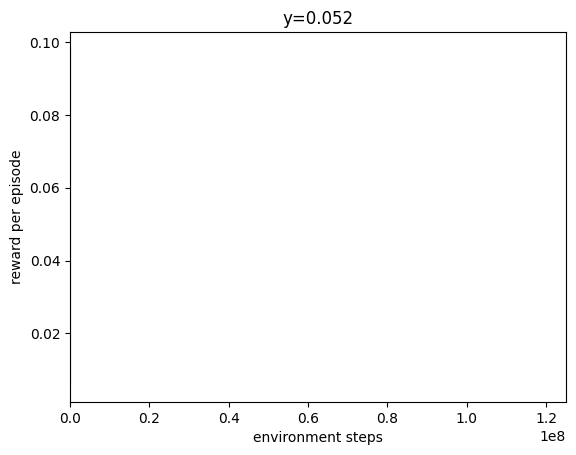

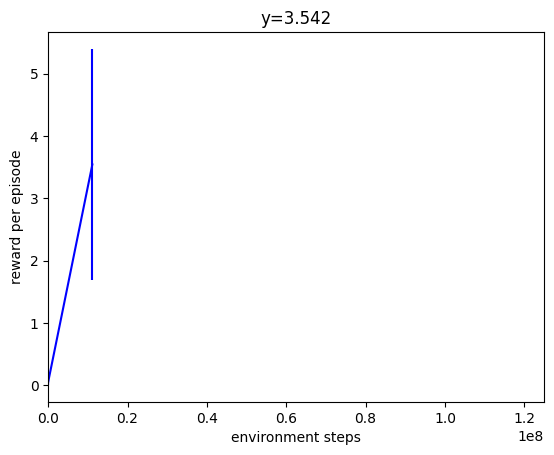

In [ ]:
# Run training and retrieve the inference function and model parameters
make_inference_fn, params, _ = train_fn(environment=env, progress_fn=progress, wrap_env_fn=wrapper.wrap_for_brax_training)

# Measure time spent in JIT compilation and training
time_to_jit = times[1] - times[0]
time_to_train = times[-1] - times[1]

print(f'Time to JIT compile: {time_to_jit}')
print(f'Time to train: {time_to_train}')


Saved the training reward plot as `training_progress_<timestamp>.png` in the `plots` directory.

In [ ]:
# Plot training reward with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(x_data, y_data, yerr=ydataerr, color="blue")
plt.xlabel('Environment steps')
plt.ylabel('Reward per episode')
plt.title(
    f'Final reward: {y_data[-1]:.3f}\n'
    f'Time to JIT: {time_to_jit}, Time to train: {time_to_train}'
)
plt.grid(True)

# Ensure the 'plots' directory exists
os.makedirs("plots", exist_ok=True)

# Generate timestamp for unique file naming
timestamp = datetime.now().strftime('%Y%m%d_%H%M')

# Define path to save the plot
plot_path = os.path.join("plots", f"training_progress_{timestamp}.png")

# Save the plot to file
plt.savefig(plot_path, bbox_inches='tight')
print(f"[✔] Plot saved to: {plot_path}")

<!-- ## Save and Load Policy -->

We can save and load the policy using the brax model API.

In [ ]:
import os

# Define model save path (within the current directory)
model_dir = './models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Get the current timestep or timestamp (you can customize this as needed)
timestep = datetime.now().strftime('%Y%m%d_%H%M%S')

# Save the model parameters directly into the model_dir with timestep in the filename
model_path = os.path.join(model_dir, f'humanoid_policy_h1_{timestep}')
model.save_params(model_path, params)

print(f"Model saved to: {model_path}")

In [ ]:
#@title Load Model and Define Inference Function
params = model.load_params(model_path)

inference_fn = make_inference_fn(params)
jit_inference_fn = jax.jit(inference_fn)

## Visualize Policy

To evaluate the learned policy, four videos were rendered from different camera angles: `track`, `side`, `back`, and `front`. These perspectives help illustrate the robot's behavior from multiple viewpoints. Please download the videos to your computer and include them in your assignment submission. Additionally, the CSV files containing recorded data, the trained model parameters, and a plot of the reward function have been saved in their respective directories: `csvs`, `models`, and `plots`. You are also required to download these files and attach them to your assignment.

In [ ]:
import pandas as pd
import os

# Get the environment to evaluate the policy
eval_env = envs.get_environment(env_name)

# JIT compile the reset and step functions for faster execution
jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)

# Set the episode length for each trial
episode_length = 1000

# Define velocities for the command (linear and angular velocities)
x_vel = 1.0
y_vel = 0.0
yaw_vel = 0.0
command = jp.array([x_vel, y_vel, yaw_vel])

# Set the phase dynamics for the environment
phase_dt = 2 * jp.pi * eval_env.dt * 1.5
phase = jp.array([0, jp.pi])

# Initialize the random number generator
rng = jax.random.PRNGKey(1)

# Initialize list to store episode data (torques, velocity, etc.)
rollout = []
modify_scene_fns = []

# Create lists to store data for each DataFrame
torque_data = []
base_height_data = []
lin_vel_body_data = []
ang_vel_body_data = []

# Get the current timestamp for filenames to make them unique
timestamp = datetime.now().strftime('%Y%m%d_%H%M')

# Define the output directory for the CSV files
output_dir = "csvs"
os.makedirs(output_dir, exist_ok=True)

# Run one episode (can change range to run multiple episodes)
for j in range(1):
    print(f"Episode {j}")
    # Reset the environment at the start of each episode
    state = jit_reset(rng)
    state.info["phase_dt"] = phase_dt
    state.info["phase"] = phase

    for i in range(episode_length):
        # Split RNG and compute the control for the current state
        act_rng, rng = jax.random.split(rng)
        ctrl, _ = jit_inference_fn(state.obs, act_rng)
        # Take a step in the environment with the computed control
        state = jit_step(state, ctrl)

        # If the episode is done, stop the loop
        if state.done:
            break

        # Skip step 0 and do not save data
        if i == 0:
            continue

        # Update the state info with the control command
        state.info["command"] = command

        # Extract data from the state for torque, base height, velocities
        torque = state.info["torques"]
        base_height = state.info["base_height"]
        lin_vel_body = state.info["lin_vel"]
        ang_vel_body = state.info["ang_vel"]

        # Create dynamic columns for torque values
        torque_dict = {"step": i}
        for j, t in enumerate(torque):
            torque_dict[f"torque_{j}"] = t  # Add dynamic column for each torque component

        # Create dynamic columns for linear body velocity with specific names
        lin_vel_dict = {"step": i}
        lin_vel_dict["lin_vel_x"] = lin_vel_body[0]  # Set x component as lin_vel_x
        lin_vel_dict["lin_vel_y"] = lin_vel_body[1]  # Set y component as lin_vel_y
        lin_vel_dict["lin_vel_z"] = lin_vel_body[2]  # Set z component as lin_vel_z

        # Create dynamic columns for angular body velocity with specific names
        ang_vel_dict = {"step": i}
        ang_vel_dict["ang_vel_x"] = ang_vel_body[0]  # Set x component as ang_vel_x
        ang_vel_dict["ang_vel_y"] = ang_vel_body[1]  # Set y component as ang_vel_y
        ang_vel_dict["ang_vel_z"] = ang_vel_body[2]  # Set z component as ang_vel_z

        # Append data to respective lists
        torque_data.append(torque_dict)
        base_height_data.append({"step": i, "base_height": base_height})
        lin_vel_body_data.append(lin_vel_dict)
        ang_vel_body_data.append(ang_vel_dict)

        # Append the current state to the rollout list
        rollout.append(state)

# Convert the collected data into Pandas DataFrames
torque_df = pd.DataFrame(torque_data)
base_height_df = pd.DataFrame(base_height_data)
lin_vel_body_df = pd.DataFrame(lin_vel_body_data)
ang_vel_body_df = pd.DataFrame(ang_vel_body_data)

# Save the data to CSV files in the output directory
csv_filenames = {
    "torque": os.path.join(output_dir, f"torque_{x_vel}_{y_vel}_{yaw_vel}_{timestamp}.csv"),
    "base_height": os.path.join(output_dir, f"base_height_{x_vel}_{y_vel}_{yaw_vel}_{timestamp}.csv"),
    "lin_vel_body": os.path.join(output_dir, f"lin_vel_body_{x_vel}_{y_vel}_{yaw_vel}_{timestamp}.csv"),
    "ang_vel_body": os.path.join(output_dir, f"ang_vel_body_{x_vel}_{y_vel}_{yaw_vel}_{timestamp}.csv")
}

# Save DataFrames to CSV files
torque_df.to_csv(csv_filenames["torque"], index=False)
base_height_df.to_csv(csv_filenames["base_height"], index=False)
lin_vel_body_df.to_csv(csv_filenames["lin_vel_body"], index=False)
ang_vel_body_df.to_csv(csv_filenames["ang_vel_body"], index=False)

print(f"CSV files saved for torque, base_height, lin_vel_body, and ang_vel_body in folder: {output_dir}.")

# Render the robot's motion for video generation (this part remains unchanged)
render_every = 1
fps = 1.0 / eval_env.dt / render_every
print(f"FPS: {fps}")
traj = rollout[::render_every]

# Define scene options for visualization
scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = True  # Show specific geometry group
scene_option.geomgroup[3] = False  # Hide other geometry group
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True  # Display contact points
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False  # Make objects opaque
scene_option.flags[mujoco.mjtVisFlag.mjVIS_PERTFORCE] = False  # Disable visualization of perturbation forces

# List of camera views to render
camera_views = ["track", "side", "back", "front"]
rendered_frames = {}

# Render and save frames for each camera view
for view in camera_views:
    frames = eval_env.render(
        traj,
        camera=view,
        scene_option=scene_option,
        width=640,
        height=480,
    )
    rendered_frames[view] = frames
    # Show video for the current view (optional)
    media.show_video(frames, fps=fps, loop=False)


## Verify Policy

Please implement your policy evaluation logic below. Your evaluation should cover the following key metrics:

- **Total torque usage**  
- **Command tracking performance**  
- **Robot's base height over time**

All evaluation results — including CSV files and plots — should be saved inside the `student_results` directory.

**Final Submission Reminder:**  
Once your evaluation is complete, compress all relevant materials — including your `Jupyter notebook`, `videos`, `CSV files`, `trained models`, `plots`, and the entire `student_results` folder — into a single archive. Upload this archive to [Moodle](https://moodle.ncku.edu.tw/) to receive your grade.



In [ ]:
import os

# Define the directory path
results_dir = "student_results"

# Create the directory if it doesn't exist
os.makedirs(results_dir, exist_ok=True)

print(f"Directory ready: {results_dir}")

# === Your policy evaluation code goes below ===
# Write code here to evaluate your trained policy.
# Save your results (e.g., torque, base height, command tracking) into CSV files,
# and generate plots. All outputs should be stored in the 'student_results' directory.
